# <b>PA005: High Value Customer Identification (Insiders)</b>

## <font color='blue'>0.0 Planejamento da solução (IOT) </font>

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização.

2. Conjunto de dados
    - Vendas de um e-commerce online, durante o período de um ano.

### Output - Saída

**1 - A indicação das pessoas que farão parte do programa de Insiders.**

Lista no formato:

| client_id | is_insiders|
| --------- | :--------: |
|   10323   |   yes / 1  |
|   32413   |   no / 0   |

</br>

**2 - Relatório com as respostas das perguntas de negócio.**

- Quem são as pessoas elegíveis para participar do programa de Insiders?

- Quantos clientes farão parte do grupo?

- Quais as principais características desses clientes?

- Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

- Qual a expectativa de faturamento desse grupo para os próximos meses?

- Quais as condições para uma pessoa ser elegível ao Insiders?

- Quais as condições para uma pessoa ser removida do Insiders?

- Qual a garantia que o programa Insiders é melhor que o restante da base?

- Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Task - Tarefas

1. **Quem são as pessoas elegíveis para participar do programa de Insiders?**

    - O que é ser elegível? O que são clientes de maior "valor"?
    
    - As respostas devem ser obtidas a partir de discussões com o time de negócios. Mas caso não conseguirmos discutir com eles, podemos elencar nossas próprias hipóteses:

        - Faturamento:
            - Alto Ticket Médio.
            - Alto LTV ( Lifetime Value ).
            - Baixa Recência ( intervalo de tempo desde a última compra ).
            - Alto Basket Size ( número de produtos na cesta ).
            - Baixa probabilidade de Churn.
            - Alta propensão de compra.
            
        - Custo:
            - Baixa taxa de devolução.

        - Experiência de compra
            - Média alta das avaliações.

</br>

2. **Quantos clientes farão parte do grupo?**

    - Número total de clientes.

    - % do grupo Insiders.

</br>

3. **Quais as principais características desses clientes?**

    - Escrever características do cliente:
        - Idade.
        - Localização.
        
    - Escrever características do consumo:
        - Atributos da clusterização.

</br>

4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders?**
    
    - Faturamento total do ano.
    
    - Faturamento do grupo Insiders.

</br>

5. **Qual a expectativa de faturamento desse grupo para os próximos meses?**

    - LTV do grupo Insiders.

    - Análise de Cohort.

</br>

6. **Quais as condições para uma pessoa ser elegível ao Insiders?**

    - Definir uma periodicidade para rodar o algoritmo de clusterização.
        - Atualiza os membros do cluster de Insiders.
        - Verifica se houve mudanças nas características dos membros dos grupo.

    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo Insiders.

</br>

7. **Quais as condições para uma pessoa ser removida do Insiders?**

    - Definir uma periocididade para rodar o algoritmo de clusterização.

    - A pessoa precisa ser dessimilar ou não-parecida com uma pessoa do grupo Insiders.

</br>

8. **Qual a garantia que o programa Insiders é melhor que o restante da base?**

    - Teste A/B.

    - Teste A/B Bayesiano.

    - Teste de Hipóteses.

</br>

9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**

    - Desconto.

    
    - Preferência de compra.
    
    - Frete.
    
    - Visita a empresa.

### Benchmark de soluções

1. **Desk Research**

    - Verificar como outras empresas estão resolvendo o problema em questão.
    
    - Separar 3 ou 4 soluções para discussão com os outros membros do squad para discustir a viabilidade dela ou se é possível aproveitar alguma parte.

### 0.0 Imports

In [209]:
import re
import numpy   as np
import pandas  as pd
import seaborn as sns

import plotly.express    as px
import matplotlib.pyplot as plt

from sklearn.cluster     import KMeans
from sklearn.metrics     import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import sklearn.preprocessing as pp

from IPython.display import HTML

### 0.1 Helper Functions

In [3]:
def jupyter_settings():

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24

    display( HTML('<style>.container { width:100% !important; } </style>') )

    # pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    # pd.set_option('display.expand_frame_repr', False)

    sns.set_theme()

jupyter_settings() 

### 0.2 Load dataset

In [4]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )


df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color="blue">1.0 Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_name = df1.columns

df1.columns = map( lambda col: re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower(), cols_name )

df1.columns


Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.2 Data dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


Variáveis como `invoice_no` e `invoice_date` não estão com o tipo correto.

### 1.4 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [12]:
# remove na
df1 = df1.dropna( subset=['description', 'customer_id'])

print('Removed data: {:.2f}'.format(1 - df1.shape[0]/ df_raw.shape[0]))

Removed data: 0.25


In [13]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.6 Change dtypes

In [14]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [15]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [16]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

df1['customer_id'] = df1['customer_id'].astype( int )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [17]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.7 Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1 Numerical Attributes

In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
desc_stats = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
desc_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurt']

desc_stats

,attributes,min,max,range,mean,median,std,skew,kurt
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


<font color='red'>**Itens para investigar**</font>

1. Quantidade negativa itens comprados pode indicar devoluções.

2. Preço unitário igual a zero ( pode ser devolução ).

#### 1.7.1 Categorical Attributes

In [20]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [96]:
# invoice number
notint_index = cat_attributes['invoice_no'].apply( lambda x: bool(re.search(r'[a-zA-Z]', x)) )

cat_attributes.loc[notint_index, 'invoice_no'].drop_duplicates().shape

(3654,)

Existem 3654 pedidos com algum com algum caractere não-numérico. As letras em `invoice_no` indica algum pedido não-convencional, como devoluções ou casos especiais. Abaixo vemos tais pedidos.

In [98]:
df1.loc[notint_index, :]#.sort_values(ascending=False)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2017-12-07,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2017-12-07,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2017-12-07,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2017-12-07,1.25,17315,United Kingdom


In [65]:
# stock code
notint_index = cat_attributes['stock_code'].apply( lambda x: bool(re.search(r'[a-zA-Z]', x)) )

cat_attributes.loc[notint_index, 'stock_code']#.drop_duplicates()

0         85123A
2         84406B
3         84029G
4         84029E
45          POST
           ...  
541778    84997C
541809    85099C
541838    84993A
541844    85049A
541853    85049E
Name: stock_code, Length: 35809, dtype: object

In [64]:
notint_index = cat_attributes['stock_code'].apply( lambda x: bool(re.search(r'^[a-zA-Z]+$', x)) )

cat_attributes.loc[notint_index, 'stock_code'].unique()#.drop_duplicates()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [63]:
df1.loc[notint_index, :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom
...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,2017-12-07,18.00,12518,Germany
541541,C581499,M,Manual,-1,2017-12-07,224.69,15498,United Kingdom
541730,581570,POST,POSTAGE,1,2017-12-07,18.00,12662,Germany
541767,581574,POST,POSTAGE,2,2017-12-07,18.00,12526,Germany


In [113]:
df1.query('stock_code == "DOT"')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
317507,564764,DOT,DOTCOM POSTAGE,1,2017-08-28,11.17,14096,United Kingdom
324002,565383,DOT,DOTCOM POSTAGE,1,2017-08-31,16.46,14096,United Kingdom
333755,566217,DOT,DOTCOM POSTAGE,1,2017-09-07,13.16,14096,United Kingdom
338829,566566,DOT,DOTCOM POSTAGE,1,2017-09-11,85.58,14096,United Kingdom
350599,567656,DOT,DOTCOM POSTAGE,1,2017-09-19,878.55,14096,United Kingdom
361584,568346,DOT,DOTCOM POSTAGE,1,2017-09-24,688.08,14096,United Kingdom
372766,569246,DOT,DOTCOM POSTAGE,1,2017-10-01,490.25,14096,United Kingdom
389983,570488,DOT,DOTCOM POSTAGE,1,2017-10-08,635.01,14096,United Kingdom
401766,571441,DOT,DOTCOM POSTAGE,1,2017-10-15,743.62,14096,United Kingdom
416463,572552,DOT,DOTCOM POSTAGE,1,2017-10-22,638.30,14096,United Kingdom


## <font color="blue">2.0 Filtragem de Variáveis </font>

In [192]:
df2 = df1.copy()

#### Explorando registros com `quantity` < 0

In [94]:
# quantity
df2.loc[df2['quantity'] < 0, :].sort_values(['invoice_date', 'customer_id']).head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2016-11-29,1.95,12472,Germany
1974,C536548,22242,5 HOOK HANGER MAGIC TOADSTOOL,-5,2016-11-29,1.65,12472,Germany
1975,C536548,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-1,2016-11-29,2.95,12472,Germany
1976,C536548,22892,SET OF SALT AND PEPPER TOADSTOOLS,-7,2016-11-29,1.25,12472,Germany
1977,C536548,22654,DELUXE SEWING KIT,-1,2016-11-29,5.95,12472,Germany


In [95]:
# o cliente 12472 fez 5 devoluções nos devoluções nos últimos 5 registros
df2.loc[df2['customer_id'] == 12472, :].sort_values(['invoice_date']).tail()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
448612,C575064,22467,GUMBALL COAT RACK,-8,2017-11-06,2.55,12472,Germany
448613,C575064,22212,FOUR HOOK WHITE LOVEBIRDS,-1,2017-11-06,2.10,12472,Germany
448614,C575064,21669,BLUE STRIPE CERAMIC DRAWER KNOB,-1,2017-11-06,1.45,12472,Germany
448615,C575064,20749,ASSORTED COLOUR MINI CASES,-1,2017-11-06,7.95,12472,Germany
451761,C575223,22973,CHILDREN'S CIRCUS PARADE MUG,-1,2017-11-07,1.65,12472,Germany


In [93]:
# filtando pelo stock_code 22467 'GUMBALL COAT RACK' vemos que ele pediu esse item múltiplas vezes, mas realizou
# algumas devoluções do mesmo, possivelment devido a algum defeito ou ficou considerou que comprou em quantidade
# excessiva e resolveu devolver alguns.
df2.loc[(df2['customer_id'] == 12472) & (df2['stock_code'] == '22467'), :].sort_values(['invoice_date'])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
9436,537201,22467,GUMBALL COAT RACK,12,2016-12-03,2.55,12472,Germany
71835,542215,22467,GUMBALL COAT RACK,18,2017-01-24,2.55,12472,Germany
83743,C543347,22467,GUMBALL COAT RACK,-6,2017-02-05,2.55,12472,Germany
121984,546843,22467,GUMBALL COAT RACK,36,2017-03-15,2.10,12472,Germany
139808,C548356,22467,GUMBALL COAT RACK,-9,2017-03-28,2.55,12472,Germany
224865,556578,22467,GUMBALL COAT RACK,6,2017-06-11,2.55,12472,Germany
253966,C559253,22467,GUMBALL COAT RACK,-2,2017-07-05,2.55,12472,Germany
276308,561037,22467,GUMBALL COAT RACK,6,2017-07-22,2.55,12472,Germany
406692,571824,22467,GUMBALL COAT RACK,36,2017-10-17,2.10,12472,Germany
448612,C575064,22467,GUMBALL COAT RACK,-8,2017-11-06,2.55,12472,Germany


#### Filtragem

In [193]:
# ==== Numerical Attributes =========
# unit price > 0.0
df2 = df2.query('unit_price > 0.01')

# stock code != [POST, D, M, PADS, DOT, CRUK]
df2 = df2.query("stock_code not in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']")

# pedidos com quantity < 0 indicam devoluções
df2_returns  = df2.query('quantity < 0')
df2_purchase = df2.query('quantity > 0')

In [194]:
df2_returns.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom


In [195]:
df2_purchase.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## <font color="blue">3.0 Feature Engineering </font>

In [196]:
df3 = df2.copy()

### Feature Creation

In [204]:
# data reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [205]:
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = ( df2_purchase[['customer_id', 'gross_revenue']]
                    .groupby('customer_id')
                    .sum()
                    .reset_index()
            )

df_ref = pd.merge(left=df_ref, right=df_monetary, how='left', on='customer_id')


# Recency
df_recency = ( df2_purchase[['customer_id', 'invoice_date']]
                    .groupby('customer_id')
                    .max()
                    .reset_index()
            )

df_recency['recency_days'] = ( df2_purchase['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

df_ref = pd.merge(left=df_ref, right=df_recency, how='left', on='customer_id')



# Frequency
df_frequency = ( df2_purchase[['customer_id', 'invoice_no']]
                    .drop_duplicates()
                    .groupby('customer_id')
                    .count()
                    .reset_index()
            ).rename(columns={'invoice_no': 'frequency'})

df_ref = pd.merge(left=df_ref, right=df_frequency, how='left', on='customer_id')

df_ref.head()


# Avg Ticket
df_avg_ticket = ( df2_purchase[['customer_id', 'gross_revenue']]
                   .groupby('customer_id')
                   .mean()
                   .reset_index()
            ).rename(columns={'gross_revenue': 'avg_ticket'})

df_avg_ticket['avg_ticket'] = np.round( df_avg_ticket['avg_ticket'], 2 )


df_ref = pd.merge(left=df_ref, right=df_avg_ticket, how='left', on='customer_id')


# Number of returns
df2_returns_grouped = ( df2_returns[['customer_id', 'invoice_no']]
                    .drop_duplicates()
                    .groupby('customer_id')
                    .count()
                    .reset_index()
                    .rename(columns={'invoice_no': 'returns'})
           )


df_ref = pd.merge(left=df_ref, right=df2_returns_grouped, how='left', on='customer_id')

df_ref.loc[ df_ref['returns'].isna(), 'returns' ] = 0


df_ref.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.15,1.0
1,13047,3232.59,56.0,9.0,18.90,7.0
2,12583,6705.38,2.0,15.0,28.90,2.0
3,13748,948.25,95.0,5.0,33.87,0.0
4,15100,876.00,333.0,3.0,292.00,3.0


In [206]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
frequency        27
avg_ticket       27
returns           0
dtype: int64

## <font color="blue">4.0 Exploratory Data Analysis </font>

In [207]:
df4 = df_ref.dropna().copy()

## <font color="blue">5.0 Data Preparation </font>

In [235]:
df5 = df4.copy()

In [236]:
df5.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.15,1.0
1,13047,3232.59,56.0,9.0,18.90,7.0
2,12583,6705.38,2.0,15.0,28.90,2.0
3,13748,948.25,95.0,5.0,33.87,0.0
4,15100,876.00,333.0,3.0,292.00,3.0


In [237]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days']  = ss.fit_transform( df5[['recency_days']] )
df5['frequency']     = ss.fit_transform( df5[['frequency']] )
df5['avg_ticket']    = ss.fit_transform( df5[['avg_ticket']] )
df5['returns']       = ss.fit_transform( df5[['returns']] )

In [238]:
df5.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns
0,17850,0.377555,2.792291,3.891594,-0.033916,0.114969
1,13047,0.135617,-0.361628,0.621543,-0.033405,3.160125
2,12583,0.524847,-0.900589,1.406356,-0.026595,0.622495
3,13748,-0.120412,0.027621,0.098335,-0.023210,-0.392557
4,15100,-0.128510,2.403041,-0.163269,0.152575,1.130021


## <font color="blue">6.0 Feature Selection </font>

In [241]:
df6 = df5.copy()

## <font color="blue">7.0 Hyperparameter Fine-Tuning </font>

In [242]:
X = df6.drop(columns=['customer_id'])

In [243]:
X.head()

,gross_revenue,recency_days,frequency,avg_ticket,returns
0,0.377555,2.792291,3.891594,-0.033916,0.114969
1,0.135617,-0.361628,0.621543,-0.033405,3.160125
2,0.524847,-0.900589,1.406356,-0.026595,0.622495
3,-0.120412,0.027621,0.098335,-0.023210,-0.392557
4,-0.128510,2.403041,-0.163269,0.152575,1.130021


### 7.1 Within-Cluster Sum of Square (WCSS)

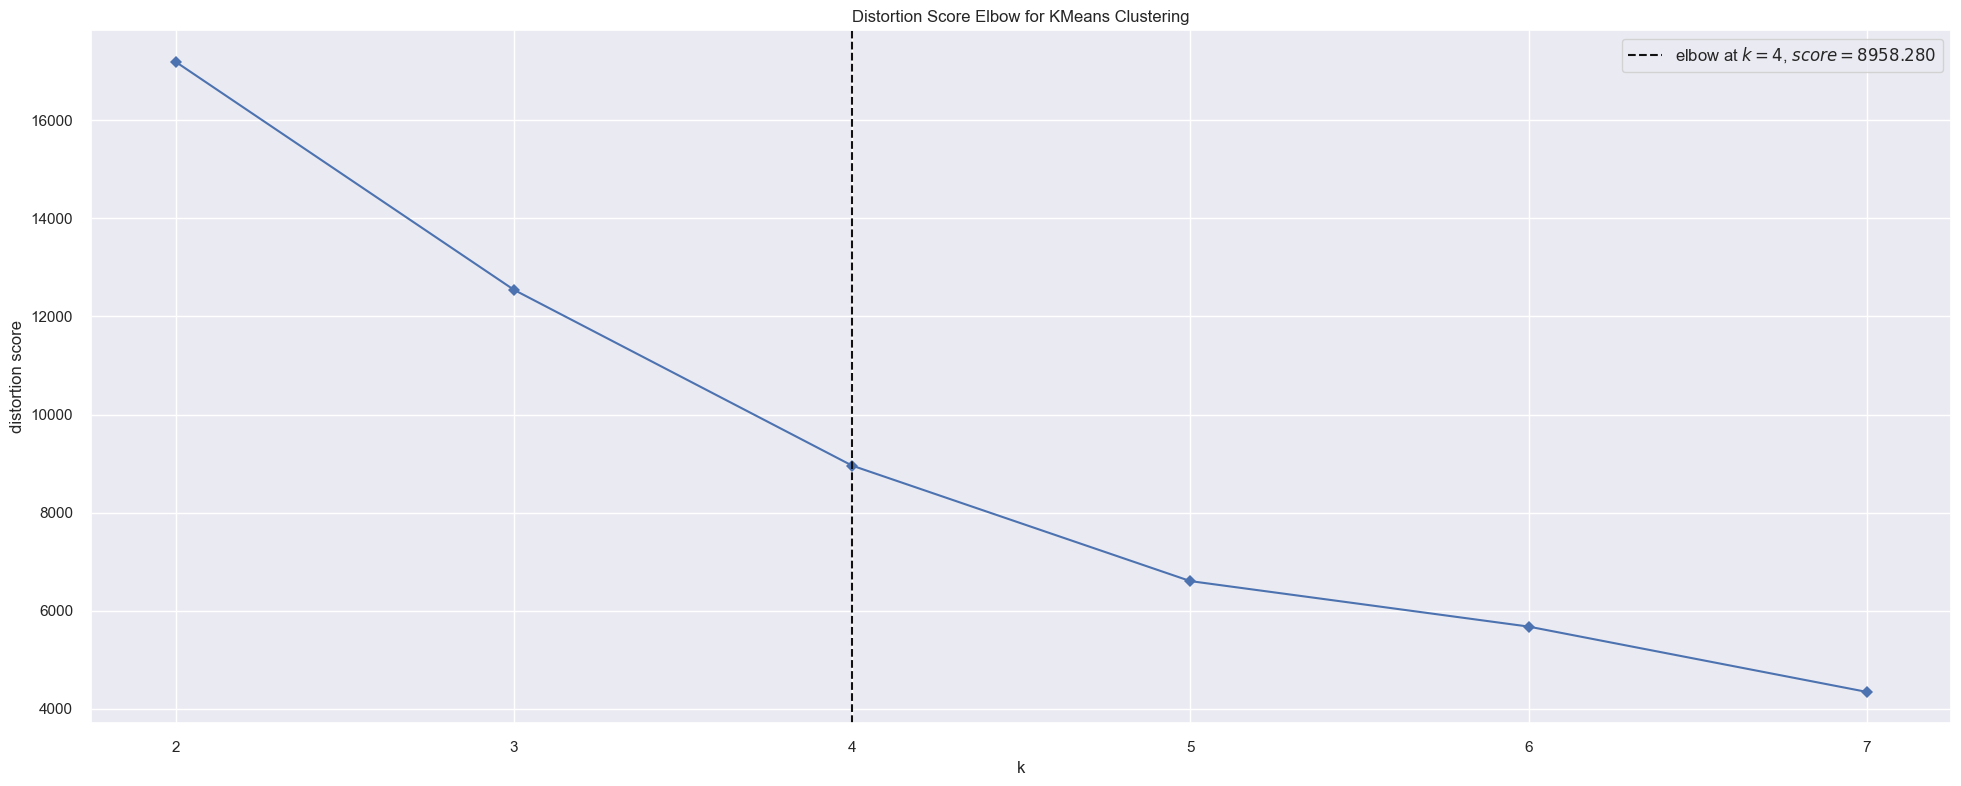

In [245]:
from yellowbrick.cluster import KElbowVisualizer

clusters = np.arange(2, 8)

kmeans_yellow = KElbowVisualizer(KMeans(), k=clusters, timings=False)
kmeans_yellow.fit(X)

kmeans_yellow.show();

### 7.2 Silhouette Score

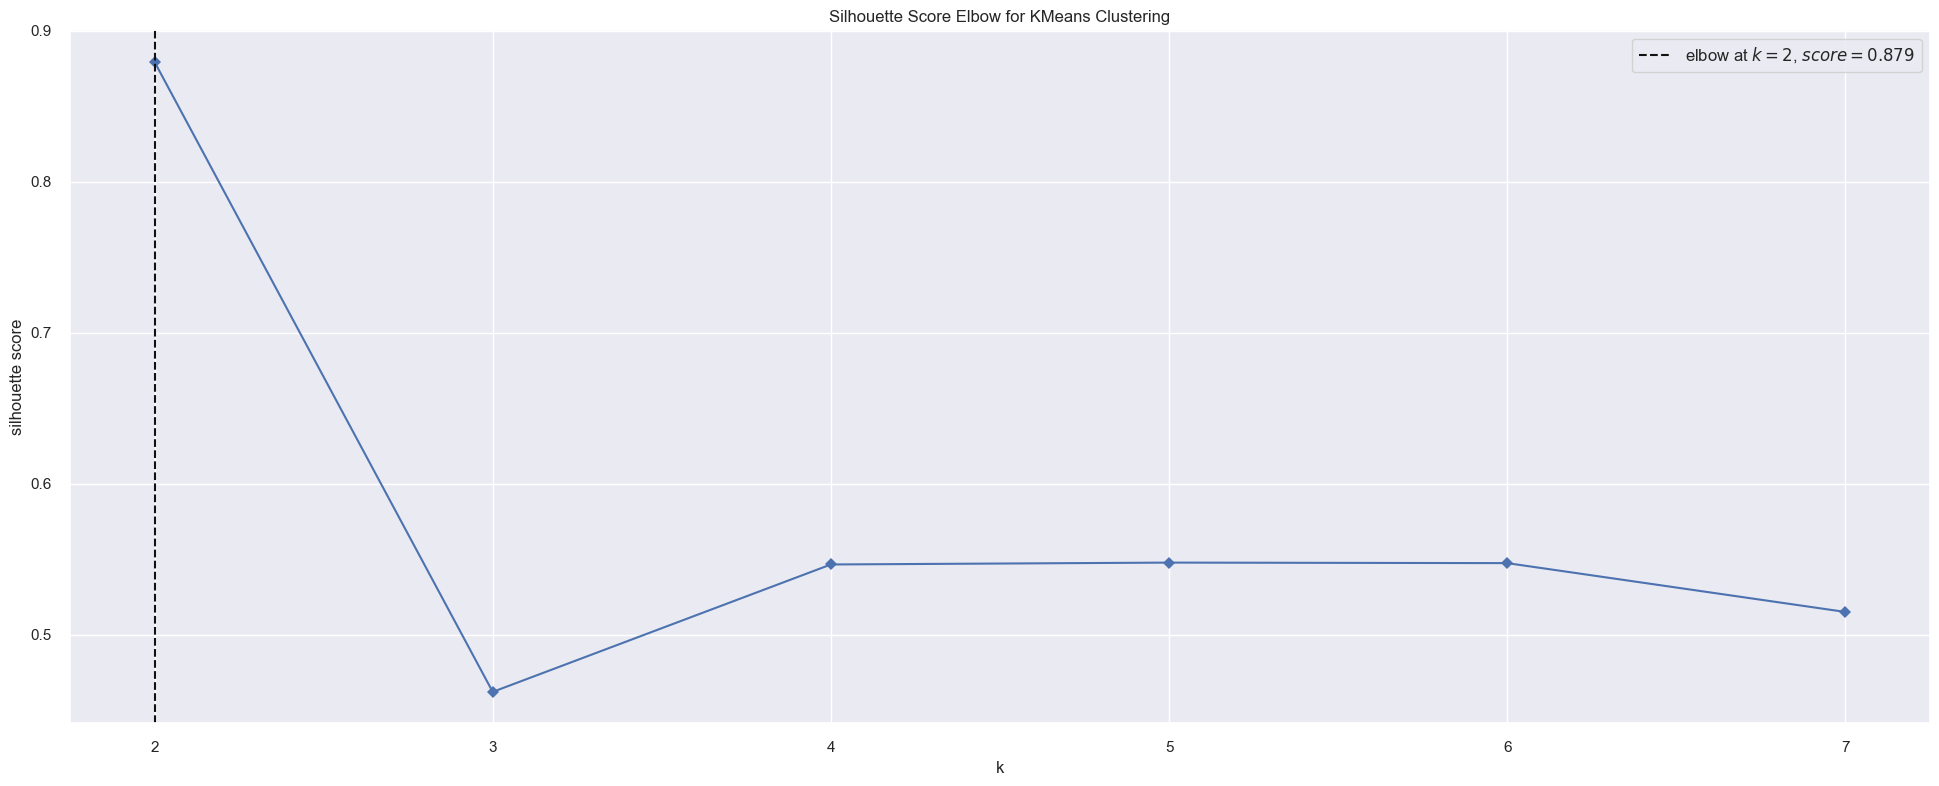

In [246]:
kmeans_yellow = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans_yellow.fit(X)

kmeans_yellow.show();

### 7.3 Silhouette Analysis

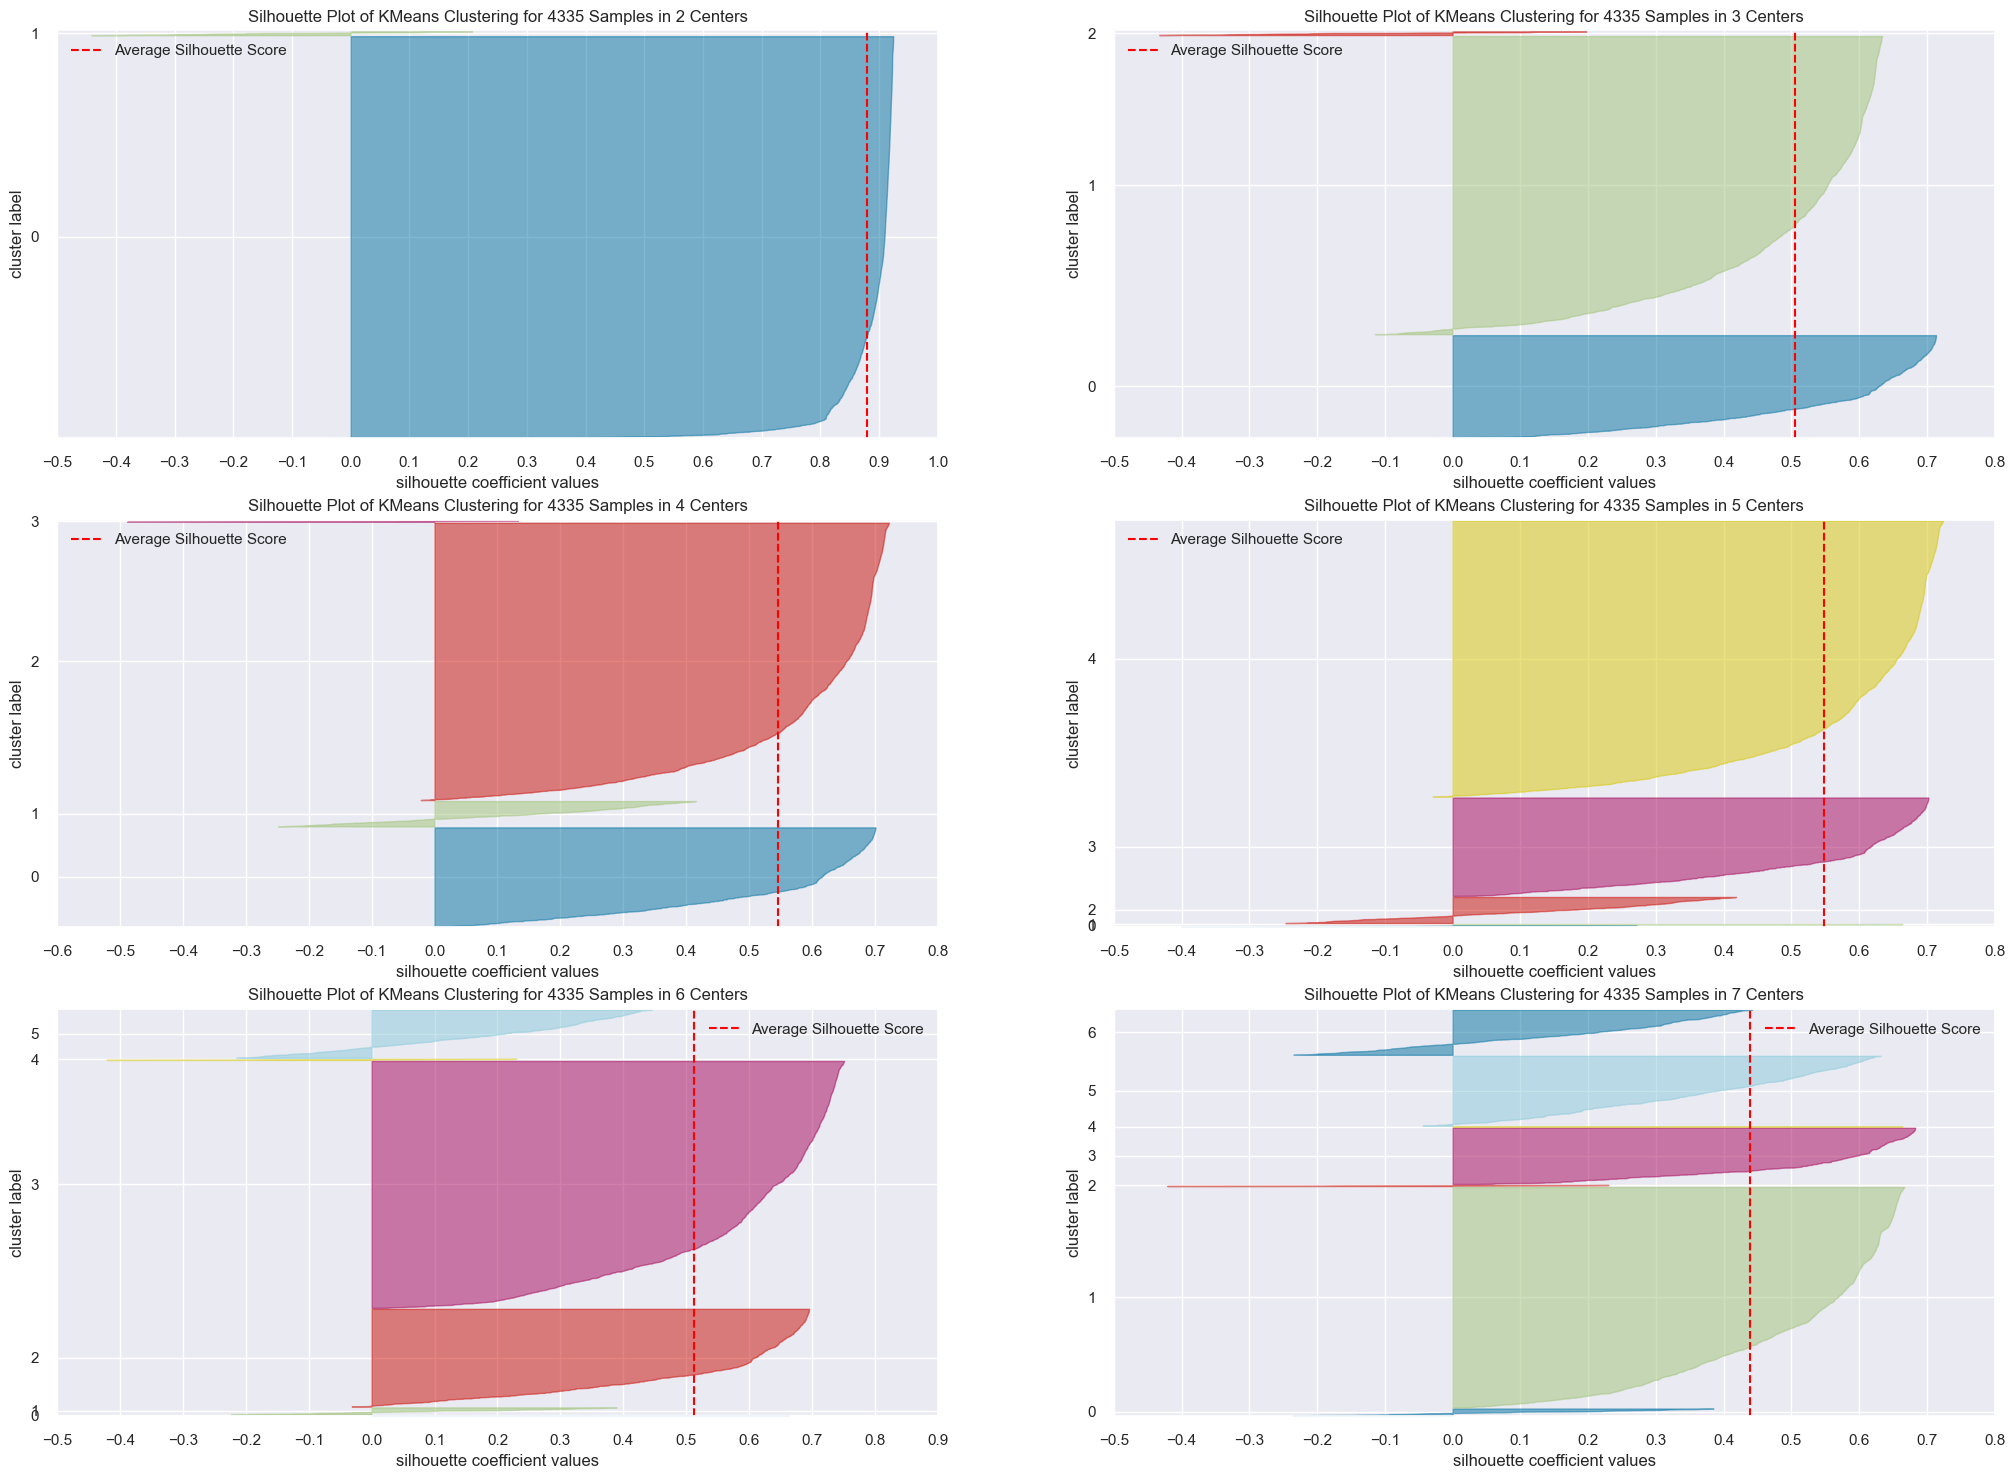

In [247]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 18))

for k, ax in zip(clusters, axes.ravel()):

    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)

    visualizer = SilhouetteVisualizer(estimator=km, colors='yellowbrick', ax=ax)
    visualizer.fit(X)
    
    visualizer.finalize();


## <font color="blue">8.0 Model Training </font>

### 8.1 K-Means

In [248]:
# model definition
k_best = 6
kmeans = KMeans(init='random', n_clusters=k_best, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X.values)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [249]:
# WCSS (Within-Cluster Sum of Square)
print('WCSS value\t: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
ss_value = silhouette_score(X, labels, metric='euclidean')
print('SS value\t: {}'.format(ss_value))

WCSS value	: 5849.187278526016
SS value	: 0.5128406785422246


## <font color="blue">9.0 Cluster Analysis </font>

In [250]:
df9 = df6.copy()

df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns,cluster
0,17850,0.377555,2.792291,3.891594,-0.033916,0.114969,2
1,13047,0.135617,-0.361628,0.621543,-0.033405,3.160125,5
2,12583,0.524847,-0.900589,1.406356,-0.026595,0.622495,5
3,13748,-0.120412,0.027621,0.098335,-0.023210,-0.392557,3
4,15100,-0.128510,2.403041,-0.163269,0.152575,1.130021,2


### 9.1 Visualization Inspection

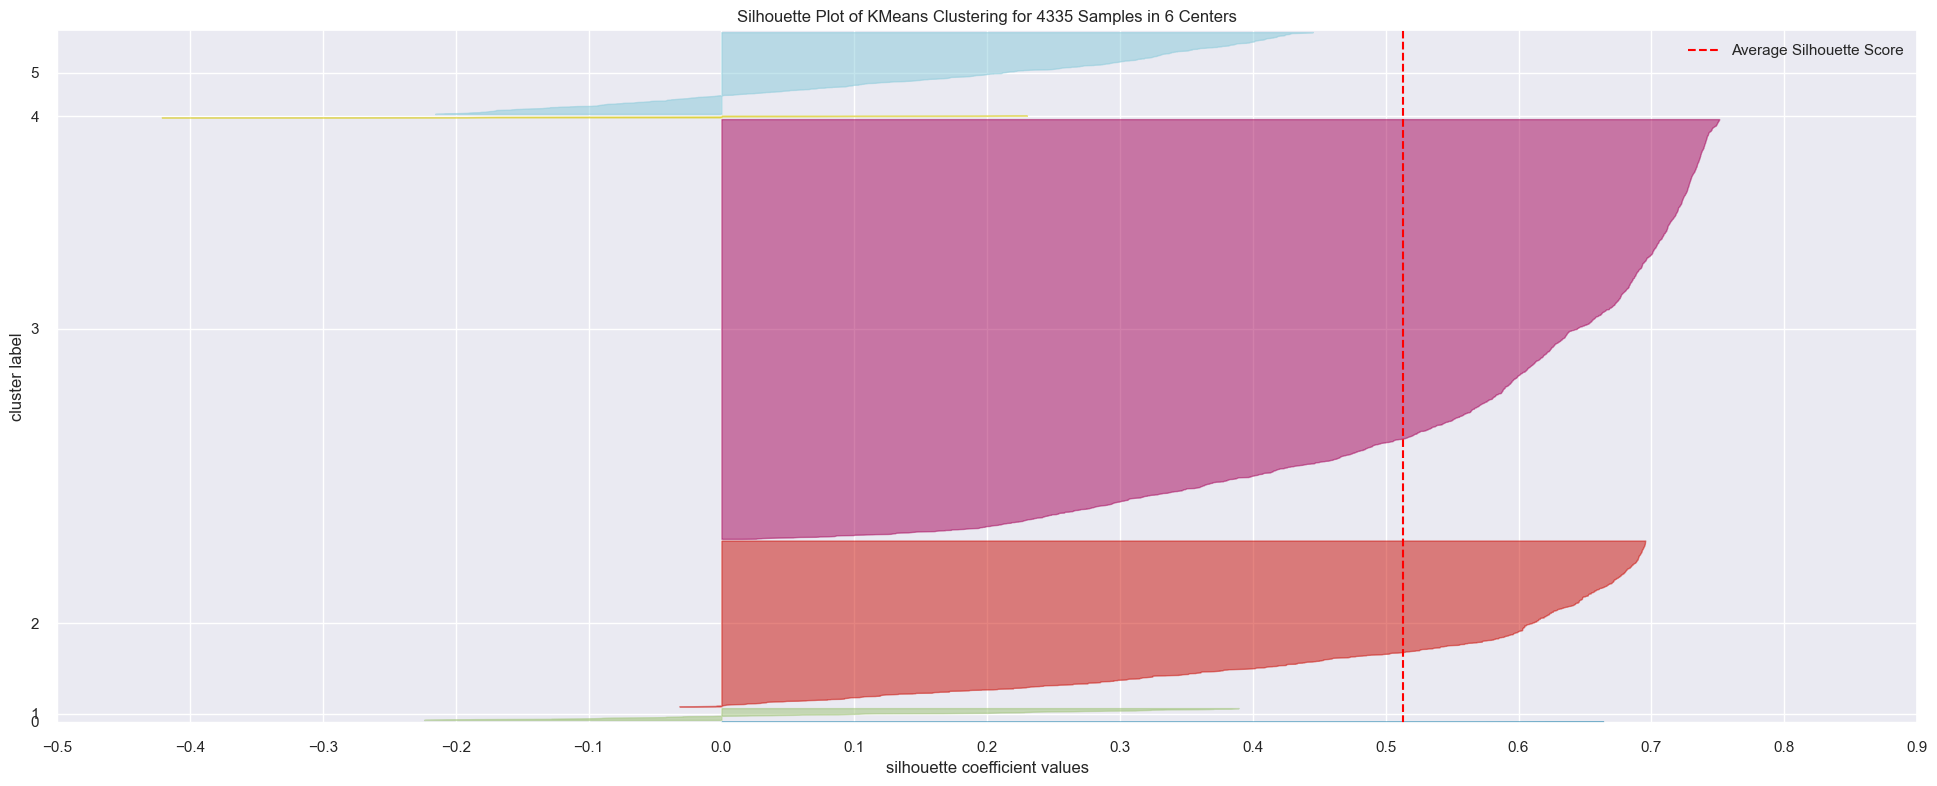

In [251]:
visualizer = SilhouetteVisualizer(estimator=kmeans, colors='yellowbrick')
visualizer.fit(X.values)
visualizer.finalize();

### 9.2 2d plot

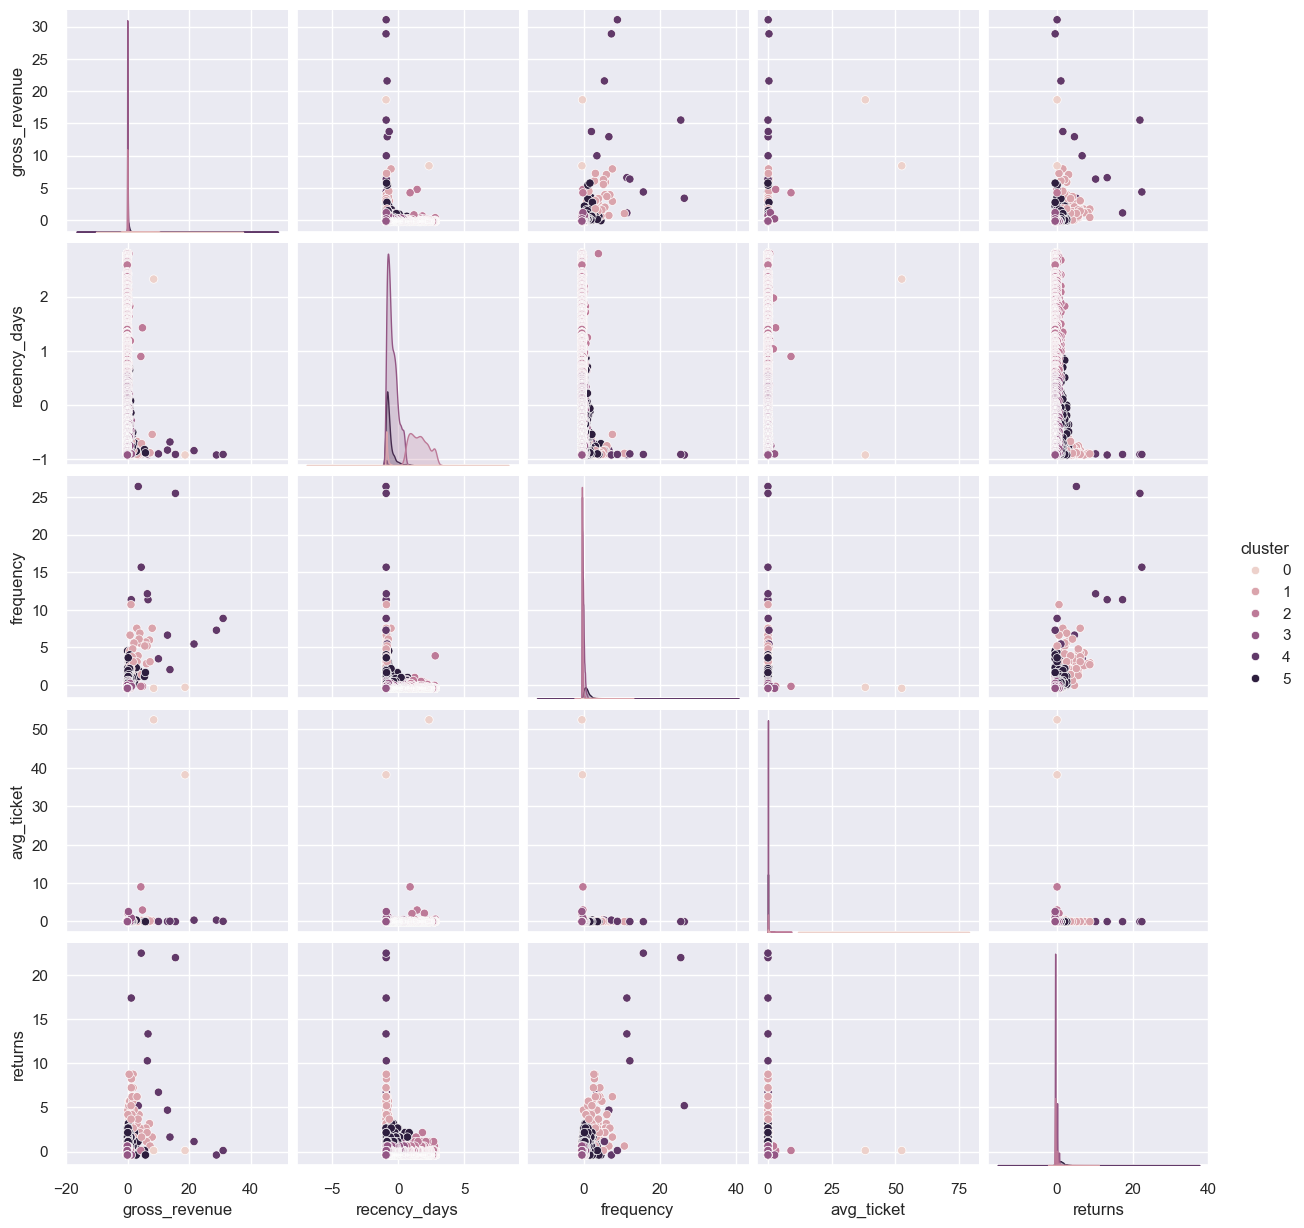

In [252]:
df_viz = df9.drop(columns=['customer_id'], axis=1)

sns.pairplot(df_viz, hue='cluster');

### 9.3 UMAP - t-SNE

**PCA** -> Matriz, Espaço de distância

**UMAP, t-SNE (2009)** -> Manifold - Topologia

In [253]:
import umap.umap_ as umap

/home/gustavo/.pyenv/versions/3.11.4/envs/ds-clusterizacao/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


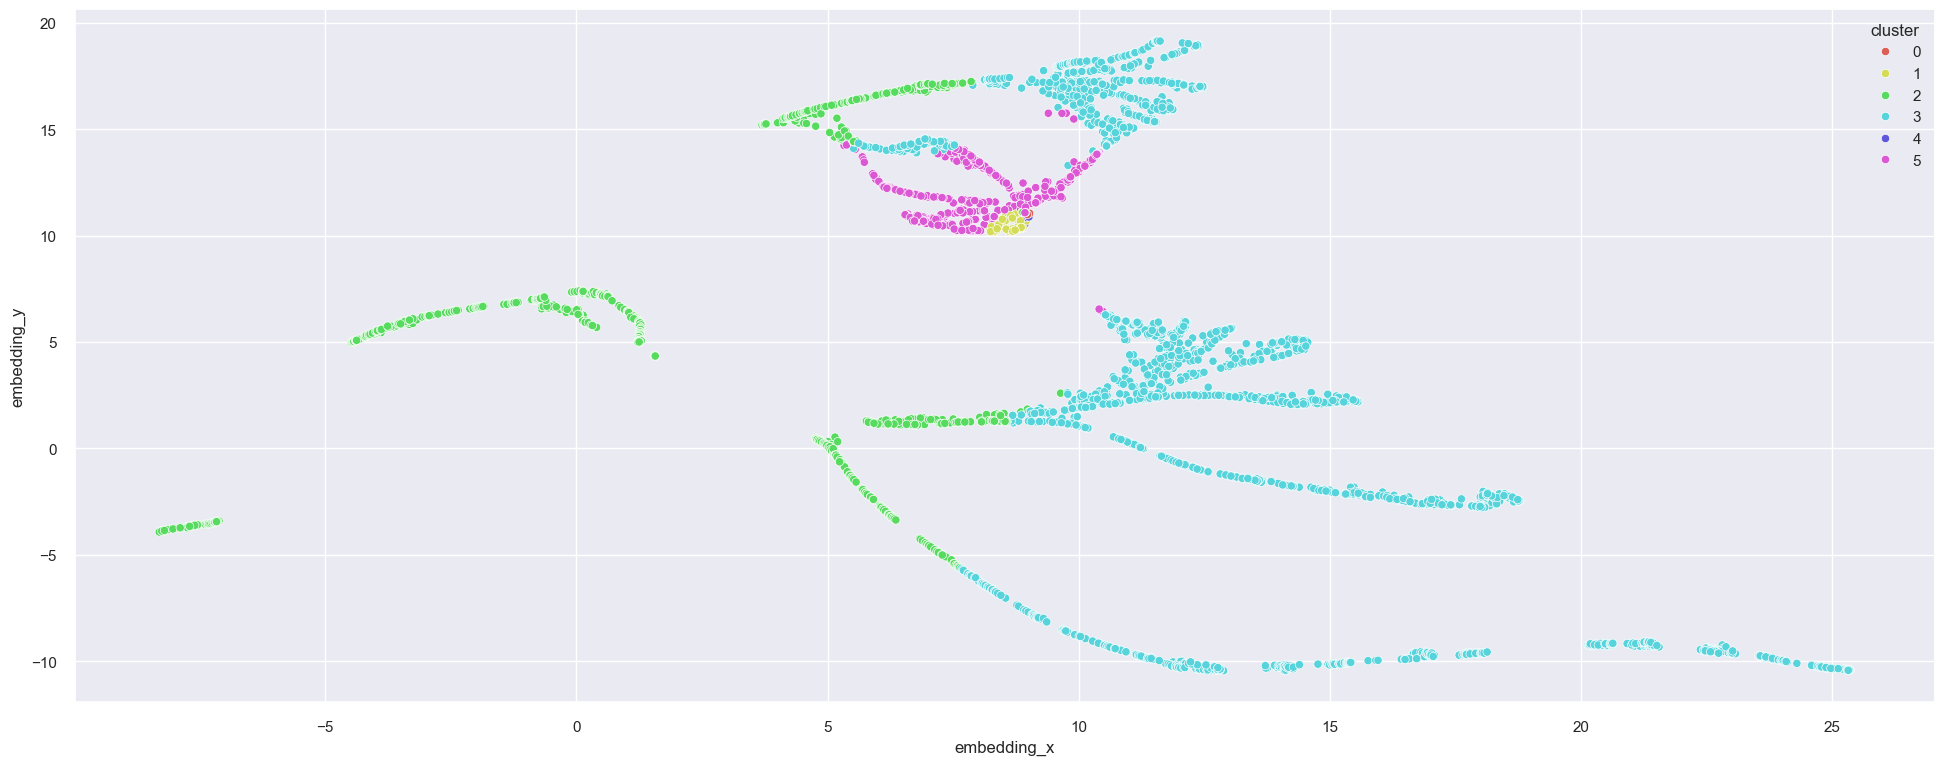

In [255]:
reducer = umap.UMAP(n_neighbors=40)

embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=k_best), data=df_viz);

/home/gustavo/.pyenv/versions/3.11.4/envs/ds-clusterizacao/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


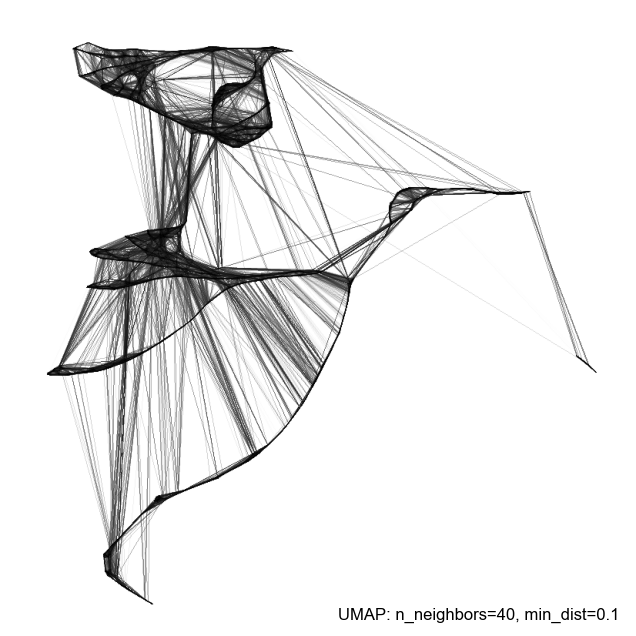

In [256]:
import umap.plot

embedding_plot = reducer.fit(X)

umap.plot.connectivity(embedding_plot);

### 9.4 Cluster Profile

In [51]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


In [122]:
# Number of customers
df_cluster = ( df9[['customer_id', 'cluster']]
                .groupby('cluster')
                .count()
                .reset_index()

        ).rename(columns={'customer_id': 'customers'})

df_cluster['perc_customer'] = 100 * df_cluster['customers'] / df_cluster['customers'].sum()

# Avg gross revenue
df_gross_revenue = ( df9[['gross_revenue', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_gross_revenue, how='left', on='cluster')


# Avg recency days
df_recency = ( df9[['recency_days', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_recency, how='left', on='cluster')


# Avg frequency
df_frequency = ( df9[['frequency', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_frequency, how='left', on='cluster')


df_ticket = ( df9[['avg_ticket', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_ticket, how='left', on='cluster')


df_cluster

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,267,6.107045,8089.028652,20.280899,19.528090,62.783157
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.969295,3.641120,25.359654


**Cluster 01: (Candidato a Insider)**
- Número de customers: 6 (0.14% dos clientes)
- Recência média: 7 dias
- Compras em média: 89 compras
- Receita média: $182.182,00


**Cluster 02:**
- Número de customers: 31 (0.71% dos clientes)
- Recência média: 14 dias
- Compras em média: 53 compras
- Receita média: $40.543,52


**Cluster 03:**
- Número de customers: 4335 (99% dos clientes)
- Recência média: 92 dias
- Compras em média: 5 compras
- Receita média: $1.372,57

## <font color="blue">10.0 Deploy to Production </font>